# Self Organization Map for Banks

## 1) Importing the packages and data pre-processing

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Credit_Card_Applications.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  690 non-null    int64  
 1   A1          690 non-null    int64  
 2   A2          690 non-null    float64
 3   A3          690 non-null    float64
 4   A4          690 non-null    int64  
 5   A5          690 non-null    int64  
 6   A6          690 non-null    int64  
 7   A7          690 non-null    float64
 8   A8          690 non-null    int64  
 9   A9          690 non-null    int64  
 10  A10         690 non-null    int64  
 11  A11         690 non-null    int64  
 12  A12         690 non-null    int64  
 13  A13         690 non-null    int64  
 14  A14         690 non-null    int64  
 15  Class       690 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 86.4 KB


In [5]:
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [6]:
df['Class'].unique()

array([0, 1], dtype=int64)

Note that we have no null values, which is great. Additionally, The "Class" only has 2 possible options, the positive one (1) and the negative one(0). 

## 2) Adjust format and keep important information

Remember that this is an unsupervised ML model. Therefore, we are only keeping the "class" to compare later when we have our clusters. 

In [7]:
X = df.iloc[:,1:-1].values # Since X = df.iloc[rows, columns] we want ALL the rows(:), but all the columns except the last one (:-1)
Y = pd.concat([df.iloc[:, 0], df.iloc[:, -1]], axis=1).values #we want all the rows, but only the first and the last column

In [15]:
from sklearn.preprocessing import MinMaxScaler
print(X[0][1])
sc = MinMaxScaler(feature_range=(0,1)) # We have to normalize before start training the model, since we are going to use euclydian distance.
X_scaled = sc.fit_transform(X)
print(X_scaled[0][1])

22.08
0.12526315789473683


## 3) Build the Model

In [16]:
from minisom  import MiniSom

# START THE MODEL
som = MiniSom(x = 10, y = 10, input_len = X_scaled.shape[1]) # We can use different parameters. We are using the default ones, but we have to deicde the nodes
                                                            # number in the horizontal and the vertical axis, taking into accound that we are converting everything
                                                            #into a 2D dimension
                                                            #Finally, we are just defining that the model is going to get 14 columns (X_scaled.shape[1] = 14)
                                                            #You can change other parameters too, like the sigma and learning rate, but in this case, let's 
                                                            #use the default ones

# INITIALIZE THE WEIGHTS
som.random_weights_init(X_scaled) #The initial weights are going to be random

# Train the Model
som.train_random(data = X_scaled, num_iteration = 1000) # 2 parameteres that need to be defined: 1) The data itself, 2) the number of iteration over the dataset
                                                        # Since the dataset is small, we are doing 1000 iterations, but it could be more than enought with 50


## 4) Check the results

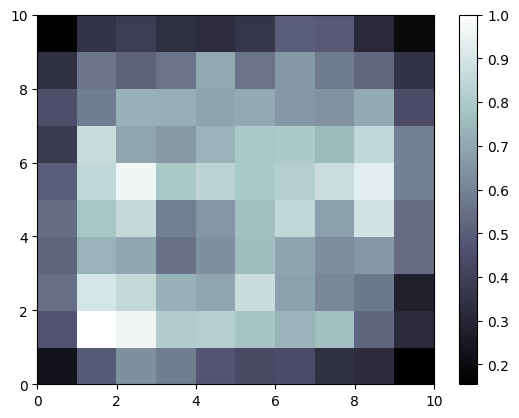

In [23]:
from pylab import bone, pcolor, colorbar, plot, show # Since we don't want to see a normal graph but insted a SOM, we are using a different library
bone() # This give us the normal "backbone" of the SOM
pcolor(som.distance_map().T) #This assing a color to a value. This value is set by the distance between the winning each node and its associated datapoint.
colorbar() # This part sets the "legends" of the colors.

We can see that in the position of nodes (1,1) and (2,2) (Looking at the bottom left to find the position) we have 2 big white squeares, which means there are just a little few of datapoints there. Therefore, you could look for outliers (fraud) there. 

However, this insight creates new questions.  How efficient is the bank when aproving or declining Credit Cards? Can we find those customers that were part of the "maybe fraud" are, but still got their credit card aproved? 

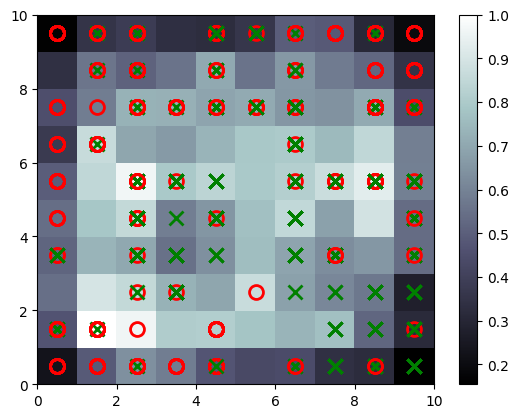

In [35]:
bone() # This give us the normal "backbone" of the SOM
pcolor(som.distance_map().T) #This assing a color to a value. This value is set by the distance between the winning each node and its associated datapoint.
colorbar() # This part sets the "legends" of the colors.

markers = ['o', 'x']
colors = ['r', 'g']

for i,x in enumerate(X_scaled): 
    w = som.winner(x) #Find the values mentioned before in the SOM
    plot(w[0] + 0.5, # x axis
         w[1] + 0.5, # y axis
         markers[Y[i][1]], # Look into the real values to see if the client got the credit approved or not
         markeredgecolor = colors[Y[i][1]], # Set the colors
         markerfacecolor = 'None', # We make the inside transparent
         markersize = 10, # marker size
         markeredgewidth = 1 #marker width 
         )
show()


There are multiple clients in the "danger" nodes. Therefore, we are going to filter only those with the green X (it means that their credit card got aproved)

Fraud detected at index 58: 1.0
Fraud detected at index 167: 1.0
Fraud detected at index 184: 1.0
Fraud detected at index 401: 1.0
Fraud detected at index 526: 1.0
Fraud detected at index 630: 1.0


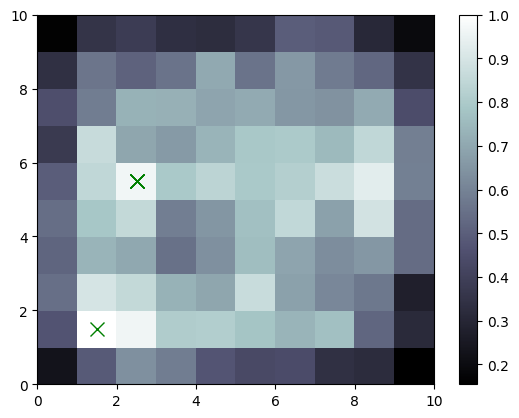

Total possible frauds with credit card approved are: 6


In [48]:
bone() # This give us the normal "backbone" of the SOM
pcolor(som.distance_map().T) #This assing a color to a value. This value is set by the distance between the winning each node and its associated datapoint.
colorbar() # This part sets the "legends" of the colors.

markers = ['o', 'x']
colors = ['r', 'g']

frauds_with_card =  np.zeros(Y[:, 1].shape) 

for i,x in enumerate(X_scaled): 

    w = som.winner(x) #Find the values mentioned before in the SOM
    if Y[i][1] == 1 and ((w[0] == 1 and w[1] == 1) or (w[0] == 2 and w[1] == 5)): # 1) Got the credicard and 2) it is in one out of the 2 possible outliers
        frauds_with_card[i] = 1
        print(f"Fraud detected at index {i}: {frauds_with_card[i]}")
        plot(w[0] + 0.5, # x axis
            w[1] + 0.5, # y axis
            markers[Y[i][1]], # Look into the real values to see if the client got the credit approved or not
            markeredgecolor = colors[Y[i][1]], # Set the colors
            markerfacecolor = 'None', # We make the inside transparent
            markersize = 10, # marker size
            markeredgewidth = 1 #marker width 
            )
        
show()
print(f'Total possible frauds with credit card approved are: ' + str(int(sum(frauds_with_card))))

Finally, let's identify this possible frauds by their id